In [1]:
import glob
from os import getcwd
import os
import pickle 
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [2]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [3]:
def summaryGridresult(grid_result, tablename, printrow=6):
   print(tablename)
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   res_tab = pd.DataFrame(grid_result.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
   res_tab = res_tab[['params','mean_train_score','std_test_score','mean_test_score','std_test_score']]
   return res_tab[:printrow]

In [4]:
# precision
def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if (true[i]) == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/(true[i])<= threshold:
                TP +=1
    return TP/len(true)

def getmetrics(true, pred):
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    return mae, r2, mse

In [5]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Sales', fontsize=16)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)

In [6]:
# set seed
seed = 12345
#Storing model outcome:

all_outcome = {}

#### import data

In [7]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)
with open("data/full_features/lasso/traindt.pkl", 'rb') as f:
   xtrain_df, ytrain_df =  pickle.load(file = f)
with open("data/full_features/lasso/testdt.pkl", 'rb') as f:
   xtest_df, ytest_df =  pickle.load(file = f)
with open("data/full_features/lasso/traindt-tf.pkl", 'rb') as f:
   xtrain, ytrain =  pickle.load(file = f)
with open("data/full_features/lasso/testdt-tf.pkl", 'rb') as f:
   xtest, ytest =  pickle.load(file = f)

In [8]:
xtrain_df.shape, ytrain_df.shape, xtest_df.shape, ytest_df.shape

((738, 34), (738, 1), (104, 34), (104, 1))

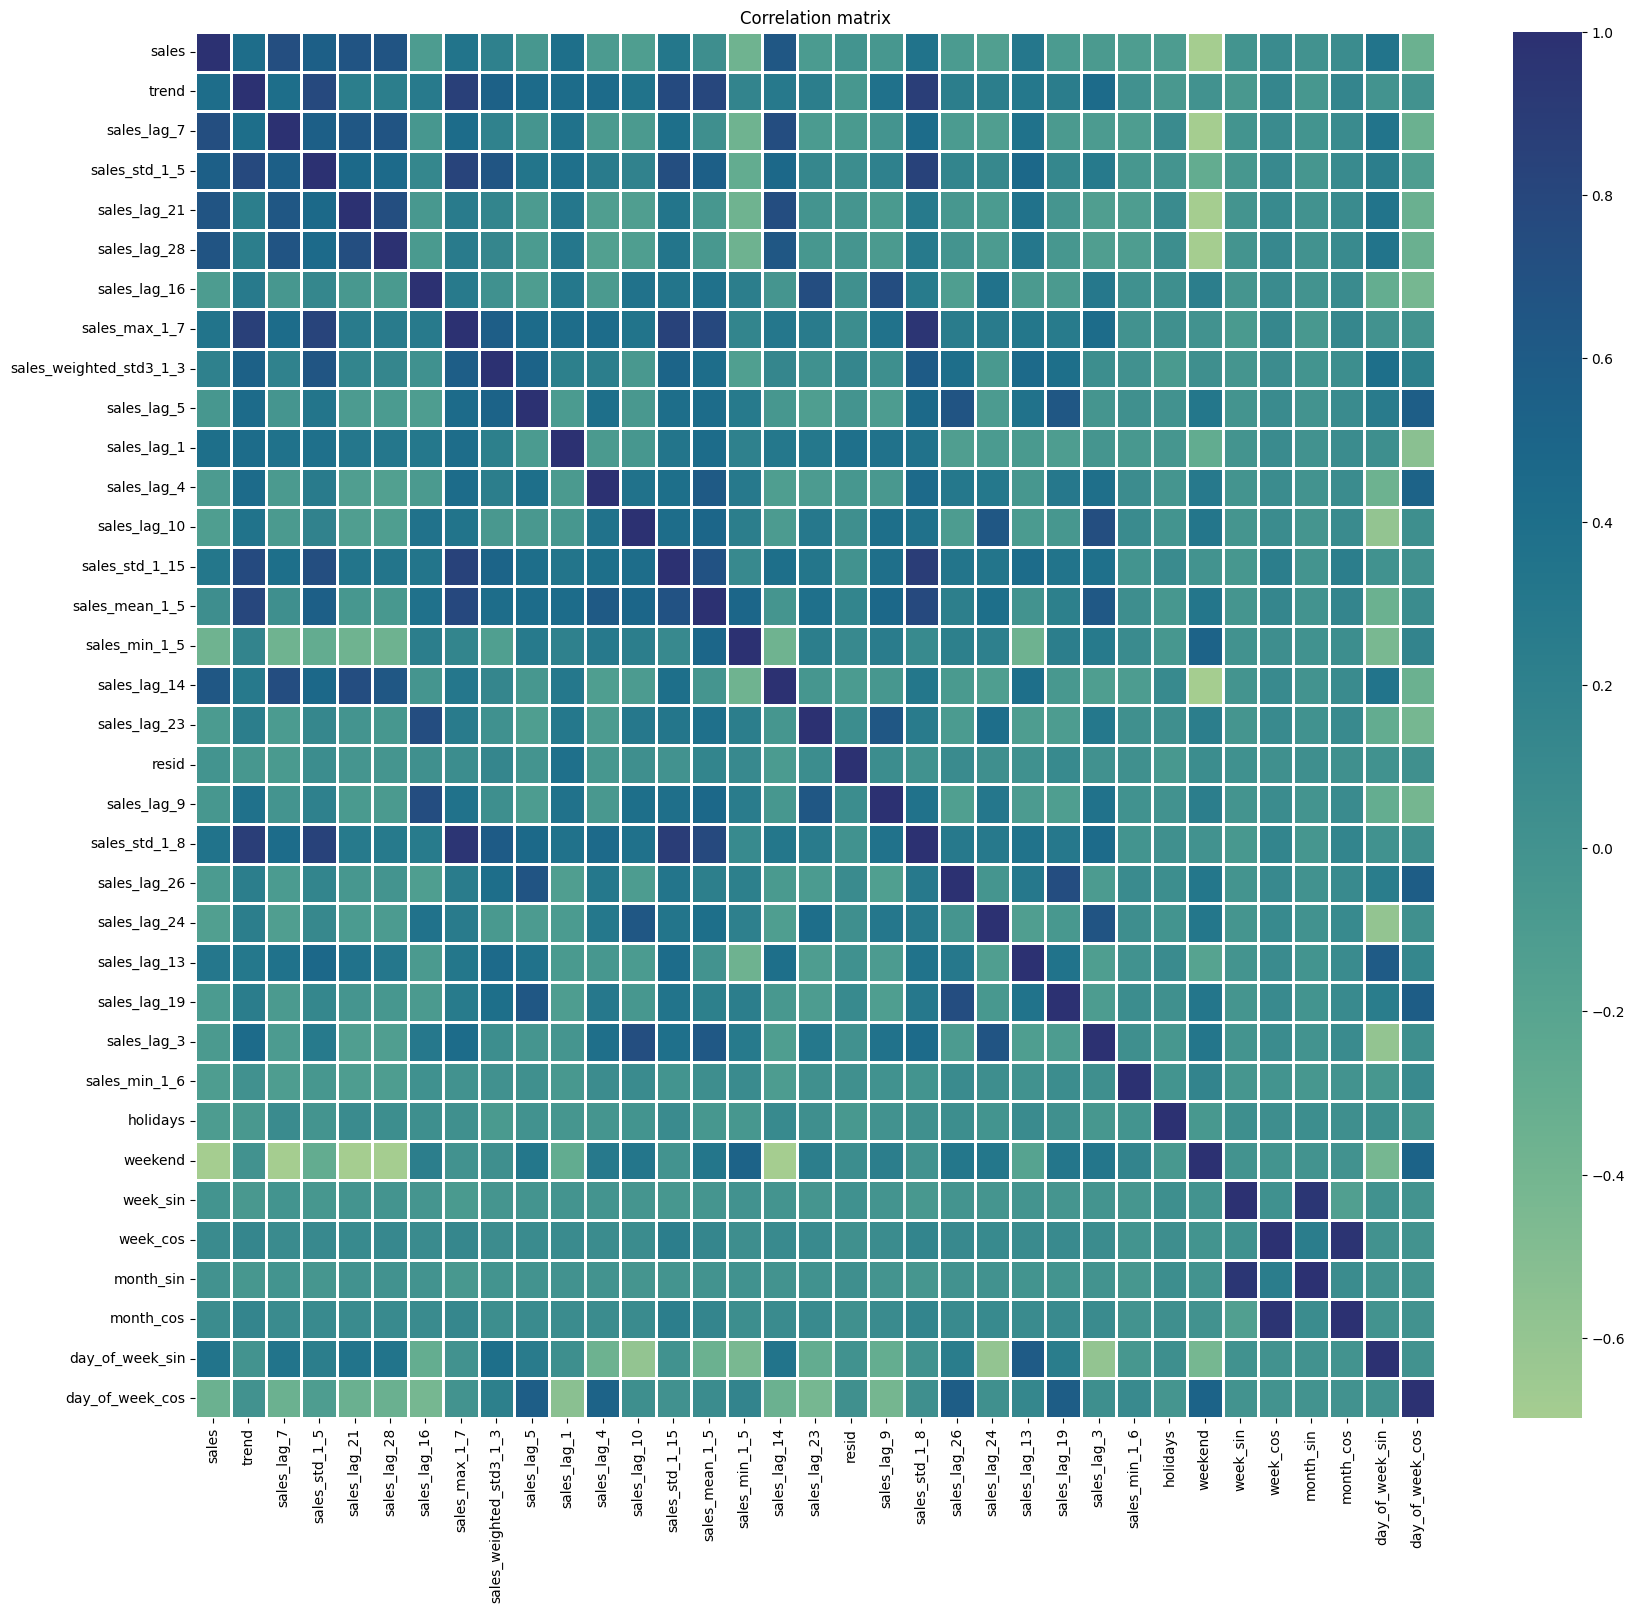

In [9]:
import seaborn as sns
test_corr_df = ytrain_df.join(xtrain_df, how = 'right')
corr_matrix = test_corr_df.reset_index().drop('Date', axis = 1).corr()
plt.figure(figsize=(20,18))
sns.heatmap(corr_matrix,annot=False,linewidth=.9,cmap='crest')
plt.title("Correlation matrix")
plt.show()

### Baseline Linear model: OLS

In [10]:
random.seed(seed)
ols = LinearRegression()
ols_grid_pams = {'fit_intercept': [True, False]}
ols_grid_mod = GridSearchCV(ols, ols_grid_pams
                       , cv = 4, scoring = 'r2', 
                       return_train_score = True, 
                       n_jobs=-1)
grid_ols_res = ols_grid_mod.fit(xtrain, np.ravel(ytrain, 'C'))

In [11]:
summaryGridresult(grid_ols_res, 'Best results for simple linear model')

Best results for simple linear model
Best: 0.660700 using {'fit_intercept': True}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
0,{'fit_intercept': True},0.754362,0.054552,0.660700,0.054552
1,{'fit_intercept': False},-0.012379,2.337641,-3.110164,2.337641


In [12]:
random.seed(seed)
ols_preds = ols_grid_mod.predict(xtest)

OLStest_out = {'mae': getmetrics(ytest, ols_preds)[0], 
               'r2':getmetrics(ytest, ols_preds)[1], 
               'mse': getmetrics(ytest, ols_preds)[2],
               'precision 10%': get_pre(ytest, ols_preds), 
               'precision 20%': get_pre(ytest, ols_preds, 0.2),
               'precision 30%': get_pre(ytest, ols_preds, 0.3)}

all_outcome['OLS'] = OLStest_out

OLStest_out

{'mae': 8.874713025008909,
 'r2': 0.7407345697818803,
 'mse': 142.0890219796533,
 'precision 10%': 0.3269230769230769,
 'precision 20%': 0.5384615384615384,
 'precision 30%': 0.6153846153846154}

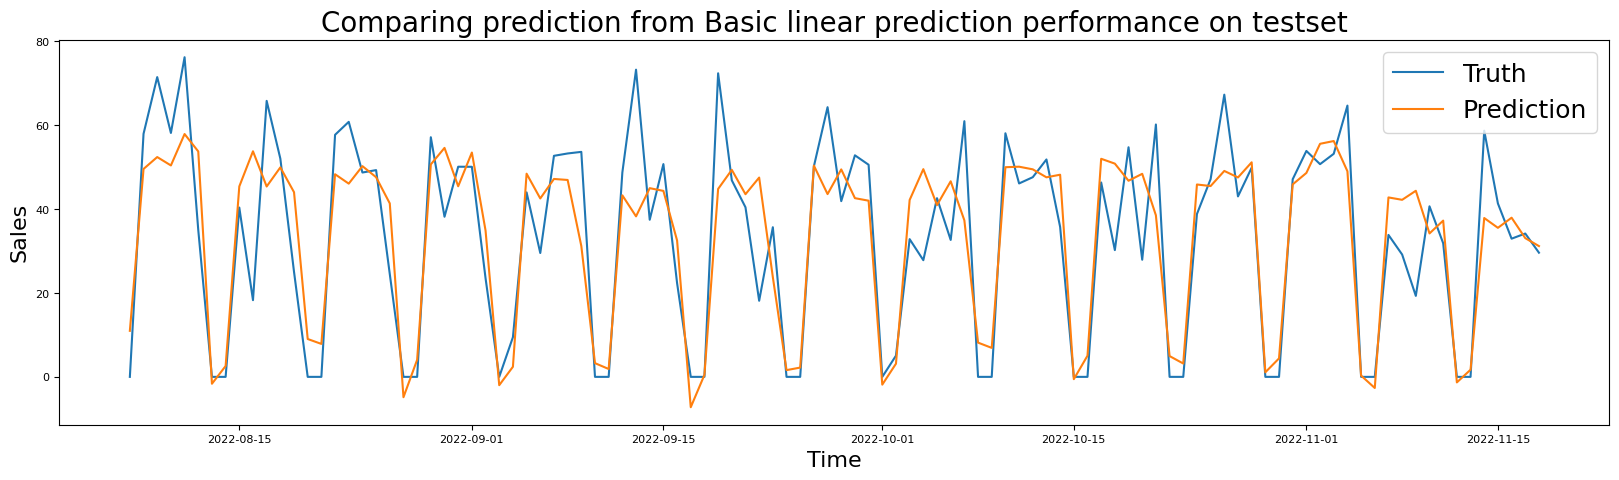

In [13]:
plotprediction(ytest_df, ols_preds.flatten(), 
               'Basic linear prediction performance on testset')

### Lasso Linear

In [14]:
# Grid search
lasso = Lasso(random_state=0, max_iter=50000)
ls_grid_pams = {'alpha':[0.01, 0.1, 1, 10, 100],
                 'selection':['cyclic','random']}

ls_grid_mod = GridSearchCV(lasso, ls_grid_pams
                       , cv = 4, scoring = 'r2',
                       return_train_score=True, 
                       n_jobs=-1)
ls_grid_res=ls_grid_mod.fit(xtrain, ytrain)

In [15]:
summaryGridresult(ls_grid_res, 'Best result for Lasso model')

Best result for Lasso model
Best: 0.668885 using {'alpha': 0.1, 'selection': 'random'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
3,"{'alpha': 0.1, 'selection': 'random'}",0.751296,0.048145,0.668885,0.048145
2,"{'alpha': 0.1, 'selection': 'cyclic'}",0.751296,0.048123,0.668865,0.048123
1,"{'alpha': 0.01, 'selection': 'random'}",0.754226,0.052394,0.663663,0.052394
0,"{'alpha': 0.01, 'selection': 'cyclic'}",0.754226,0.052405,0.663652,0.052405
5,"{'alpha': 1, 'selection': 'random'}",0.717374,0.054480,0.643882,0.054480
4,"{'alpha': 1, 'selection': 'cyclic'}",0.717378,0.054527,0.643871,0.054527


In [16]:
random.seed(seed)
ls_preds = ls_grid_mod.predict(xtest)

LSTest_out = {'mae': getmetrics(ytest, ls_preds)[0], 
               'r2':getmetrics(ytest, ls_preds)[1], 
               'mse': getmetrics(ytest, ls_preds)[2],
               'precision 10%': get_pre(ytest, ls_preds), 
               'precision 20%': get_pre(ytest, ls_preds, 0.2),
               'precision 30%': get_pre(ytest, ls_preds, 0.3)}
all_outcome['lasso'] = LSTest_out
LSTest_out


{'mae': 8.841137423028254,
 'r2': 0.7395008151293763,
 'mse': 142.765174568873,
 'precision 10%': 0.2980769230769231,
 'precision 20%': 0.5192307692307693,
 'precision 30%': 0.5865384615384616}

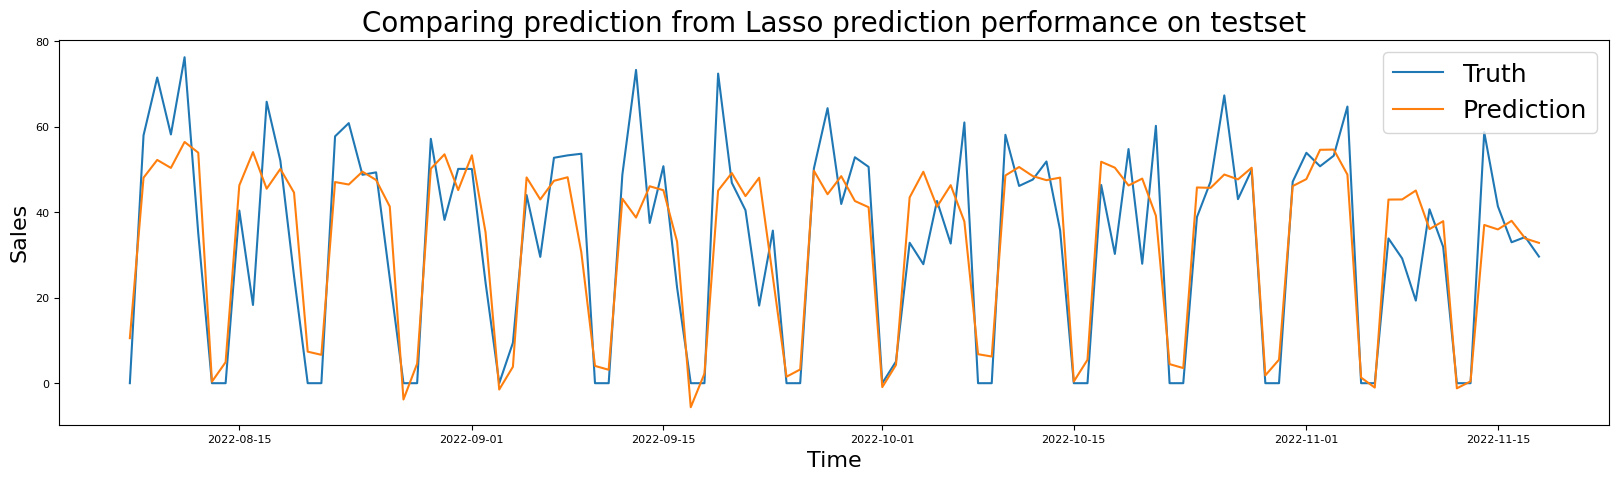

In [17]:
plotprediction(ytest_df, ls_preds, 
               'Lasso prediction performance on testset')

# Ridge Linear

In [18]:
# Grid search
random.seed(seed)
ridge = Ridge(random_state=0, max_iter=50000)
rid_grid_pams = {'alpha':[0.01, 0.1, 1, 10, 100],
                 'solver':['svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag']}
rid_grid_mod = GridSearchCV(ridge, rid_grid_pams,
                           cv = 4, scoring = 'r2',
                           return_train_score=True)
rid_grid_res = rid_grid_mod.fit(xtrain, ytrain)

In [19]:
summaryGridresult(rid_grid_res, 'Best result for Ridge Linear model')

Best result for Ridge Linear model
Best: 0.670863 using {'alpha': 10, 'solver': 'lsqr'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
18,"{'alpha': 10, 'solver': 'lsqr'}",0.752833,0.044531,0.670863,0.044531
17,"{'alpha': 10, 'solver': 'sparse_cg'}",0.752870,0.044476,0.670833,0.044476
19,"{'alpha': 10, 'solver': 'sag'}",0.752866,0.045191,0.670344,0.045191
16,"{'alpha': 10, 'solver': 'cholesky'}",0.752912,0.045241,0.670214,0.045241
15,"{'alpha': 10, 'solver': 'svd'}",0.752912,0.045241,0.670214,0.045241
23,"{'alpha': 100, 'solver': 'lsqr'}",0.734806,0.031496,0.667216,0.031496


In [20]:
random.seed(seed)
rid_preds = rid_grid_mod.predict(xtest)

RidTest_out = {'mae': getmetrics(ytest, rid_preds)[0], 
               'r2':getmetrics(ytest, rid_preds)[1], 
               'mse': getmetrics(ytest, rid_preds)[2],
               'precision 10%': get_pre(ytest, rid_preds), 
               'precision 20%': get_pre(ytest, rid_preds, 0.2),
               'precision 30%': get_pre(ytest, rid_preds, 0.3)}
all_outcome['Ridge']=RidTest_out
RidTest_out


{'mae': 8.883841984741577,
 'r2': 0.739072682581777,
 'mse': 142.99981030459315,
 'precision 10%': 0.2980769230769231,
 'precision 20%': 0.5288461538461539,
 'precision 30%': 0.6153846153846154}

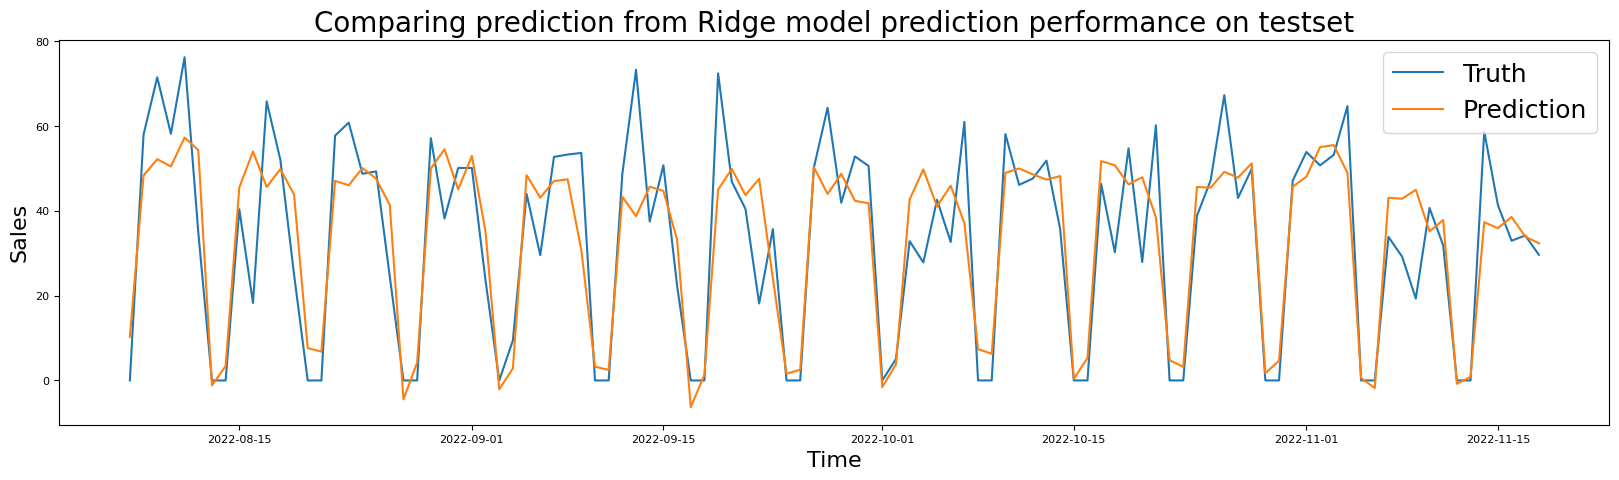

In [21]:
plotprediction(ytest_df, rid_preds.flatten(), 
               'Ridge model prediction performance on testset')

# KNN Knearest neighbors

In [22]:
# Grid search
random.seed(seed)
knn = KNeighborsRegressor()
knn_grid_pams = {'n_neighbors' : [5,10,15,20],
               'weights':['uniform', 'distance']}
knn_grid_mod = GridSearchCV(knn, knn_grid_pams
                       , cv = 4, scoring = 'r2',
                       return_train_score=True)

knn_grid_res = knn_grid_mod.fit(xtrain, ytrain)

In [23]:
summaryGridresult(knn_grid_res, 'Best results for KNN model')

Best results for KNN model
Best: 0.546830 using {'n_neighbors': 20, 'weights': 'distance'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
7,"{'n_neighbors': 20, 'weights': 'distance'}",1.000000,0.102779,0.546830,0.102779
5,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.102038,0.545630,0.102038
6,"{'n_neighbors': 20, 'weights': 'uniform'}",0.722380,0.105498,0.543468,0.105498
4,"{'n_neighbors': 15, 'weights': 'uniform'}",0.733256,0.105631,0.542189,0.105631
3,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.091768,0.540537,0.091768
2,"{'n_neighbors': 10, 'weights': 'uniform'}",0.751326,0.094778,0.537669,0.094778


In [24]:
knn_preds = knn_grid_mod.predict(xtest)

knn_out = {'mae': getmetrics(ytest, knn_preds)[0], 
               'r2':getmetrics(ytest, knn_preds)[1], 
               'mse': getmetrics(ytest, knn_preds)[2],
               'precision 10%': get_pre(ytest, knn_preds), 
               'precision 20%': get_pre(ytest, knn_preds, 0.2),
               'precision 30%': get_pre(ytest, knn_preds, 0.3)}
all_outcome['KNN15']=knn_out

knn_out

{'mae': 8.589567592552008,
 'r2': 0.7314918419343298,
 'mse': 147.15444917207805,
 'precision 10%': 0.4230769230769231,
 'precision 20%': 0.5961538461538461,
 'precision 30%': 0.7115384615384616}

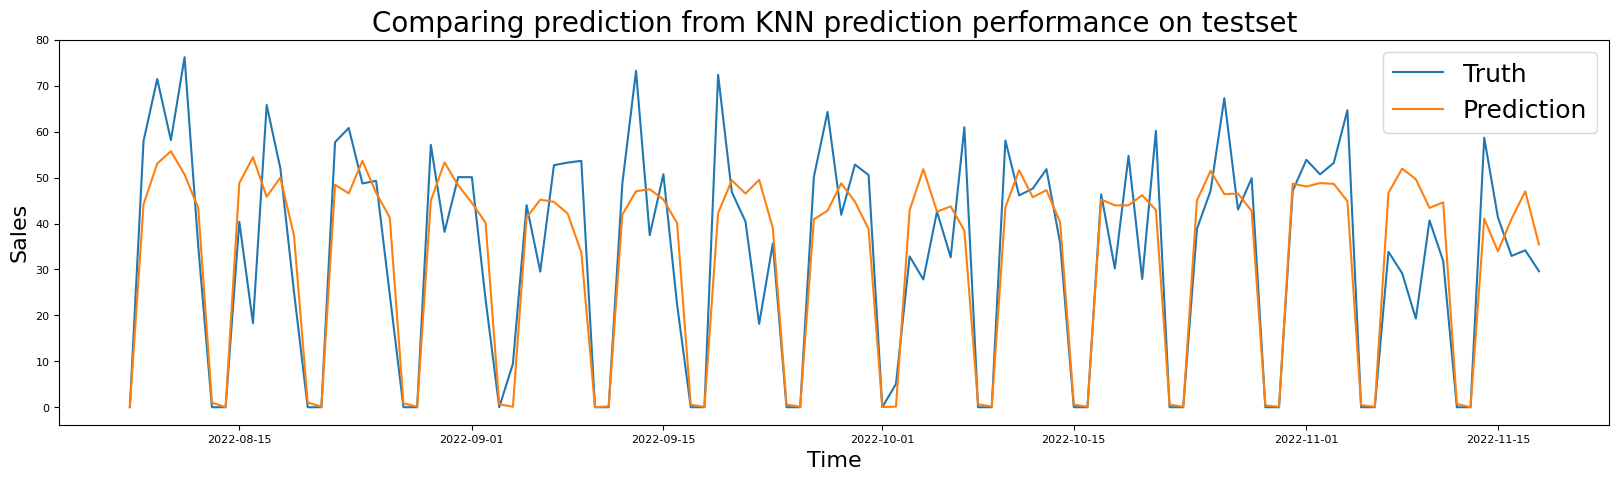

In [25]:
plotprediction(ytest_df, knn_preds.flatten(), 
               'KNN prediction performance on testset')

In [26]:
o_trs = {'mse':[],'mae':[], 'r2':[], 'precision 10%':[], 'precision 20%':[],'precision 30%':[],}
index = all_outcome.keys()
i =  0
for mod in index:
    for m in ['mse','mae', 'r2', 'precision 10%', 'precision 20%', 'precision 30%']:
        o_trs[m].append(all_outcome[mod][m])
    
pd.DataFrame(data=o_trs, index=index)

,mse,mae,r2,precision 10%,precision 20%,precision 30%
OLS,142.089022,8.874713,0.740735,0.326923,0.538462,0.615385
lasso,142.765175,8.841137,0.739501,0.298077,0.519231,0.586538
Ridge,142.999810,8.883842,0.739073,0.298077,0.528846,0.615385
KNN15,147.154449,8.589568,0.731492,0.423077,0.596154,0.711538
